In [1]:
import sys
import math
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms 
import torch.nn.functional as F
import joblib
import torch
import os
import importlib  
import pandas as pd

from thop import profile
from collections import defaultdict
%matplotlib inline

In [2]:
torch.manual_seed(1)
np.random.seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
DATA_DIR = "/scratch/dz1158/"

In [4]:
os.chdir(DATA_DIR+"Yolov5-pytorch")

In [5]:
import warnings
warnings.filterwarnings("ignore")

import thop
from models.yolov5 import Yolov5
from models.yolo_repvgg import Yolo_repvgg
from models.yolo_mobilenet import Yolo_mobilenetv2
from models.yolo_ghostnet import Yolo_ghostnet
from models.yolo_mobilenetv3 import Yolo_mobilenetv3
from models.yolo_resnet18 import Yolo_resnet18

from models.yolo_efficientnet import Yolo_efficientnetv2
from models.yolo_inceptionv4 import Yolo_inceptionv4
from models.yolo_densenet121 import Yolo_densenet121

import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
# v5 = torch.load(DATA_DIR+'/Yolov5-pytorch/runs/train/yolov5/weights/last.pt')
# repvgg = torch.load(DATA_DIR+'Yolov5-pytorch/runs/train/yolo_repvgg/weights/last.pt')
# mobilenetv2 = torch.load(DATA_DIR+'Yolov5-pytorch/runs/train/yolo_mobilenet/weights/last.pt')
# mobilenetv3 = torch.load(DATA_DIR+'Yolov5-pytorch/runs/train/yolo_mobilenetv3/weights/last.pt')
# ghostnet = torch.load(DATA_DIR+'Yolov5-pytorch/runs/train/yolo_ghostnet/weights/last.pt')
# resnet18 = torch.load(DATA_DIR+'Yolov5-pytorch/runs/train/yolo_resnet18/weights/last.pt')

In [6]:
v5s = torch.load('/scratch/dz1158/Yolov5-pytorch/runs/train/yolov5s/weights/last.pt')
v5m = torch.load('/scratch/dz1158/Yolov5-pytorch/runs/train/yolov5m/weights/last.pt')
v5n = torch.load('/scratch/dz1158/Yolov5-pytorch/runs/train/yolov5n/weights/last.pt')

repvgg = torch.load('/scratch/dz1158/Yolov5-pytorch/runs/train/yolo_repvgg/weights/last.pt')
mobilenetv2 = torch.load('/scratch/dz1158/Yolov5-pytorch/runs/train/yolo_mobilenet/weights/last.pt')
mobilenetv3 = torch.load('/scratch/dz1158/Yolov5-pytorch/runs/train/yolo_mobilenetv3/weights/last.pt')
ghostnet = torch.load('/scratch/dz1158/Yolov5-pytorch/runs/train/yolo_ghostnet/weights/last.pt')
resnet18 = torch.load('/scratch/dz1158/Yolov5-pytorch/runs/train/yolo_resnet18/weights/last.pt')

inceptionv4 = torch.load('/scratch/dz1158/Yolov5-pytorch/runs/train/yolo_inceptionv4/weights/last.pt')
densenet = torch.load('/scratch/dz1158/Yolov5-pytorch/runs/train/yolo_densenet/weights/last.pt')

In [7]:
saved_model_names = ['Yolov5s', 'Yolov5m', 'Yolov5n', 
                     'Yolo_repvgg', 'Yolo_mobilenetv2', 'Yolo_mobilenetv3', 'Yolo_ghostnet', 'Yolo_resnet18',
                     "Yolo_inceptionnetv4", "Yolo_densenet"]

saved_models = [v5s["model"], v5m["model"], v5n["model"],
                repvgg["model"], mobilenetv2["model"], mobilenetv3["model"], ghostnet["model"], resnet18["model"],
                inceptionv4["model"], densenet["model"]
               ]

model_weights = defaultdict()
for i in saved_model_names:
    model_weights[i] = -1

for ms in range(len(saved_models)): 
    params = []
    for param in saved_models[ms].parameters():
        params.append(param.view(-1))
    params = torch.cat(params)
    model_weights[saved_model_names[ms]] = params.numpy()

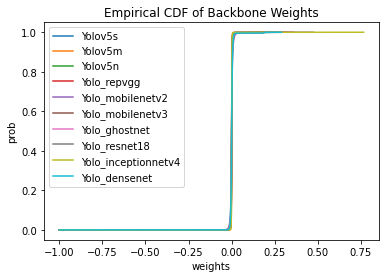

In [10]:
for k, v in model_weights.items():
    plt.plot(np.sort(v)/np.max(np.abs(v)), np.linspace(0, 1, len(v), endpoint=False), label = k)
#     plt.plot(np.sort(v), np.linspace(0, 1, len(v), endpoint=False), label = k)
plt.title("Empirical CDF of Backbone Weights")
plt.xlabel("weights")
plt.ylabel("prob")
plt.legend()
plt.show()

In [9]:
for k, v in model_weights.items():
    print("model:", k, "min:", np.min(v), "max:", np.max(v), "mean:", np.mean(v), "sd:", np.std(v))

model: Yolov5s min: -7.496 max: 2.436 mean: 0.0003707 sd: 0.04636
model: Yolov5m min: -7.727 max: 1.935 mean: 0.0002902 sd: 0.03397
model: Yolov5n min: -7.69 max: 2.33 mean: 0.000668 sd: 0.0737
model: Yolo_repvgg min: -6.887 max: 1.756 mean: 0.0002048 sd: 0.03568
model: Yolo_mobilenetv2 min: -5.496 max: 2.611 mean: 0.003841 sd: 0.07733
model: Yolo_mobilenetv3 min: -5.457 max: 1.959 mean: 0.002253 sd: 0.06128
model: Yolo_ghostnet min: -5.45 max: 1.943 mean: 0.002092 sd: 0.0583
model: Yolo_resnet18 min: -6.72 max: 1.555 mean: -0.000502 sd: 0.027
model: Yolo_inceptionnetv4 min: -6.562 max: 5.023 mean: 0.000476 sd: 0.02946
model: Yolo_densenet min: -5.266 max: 1.52 mean: 0.003801 sd: 0.07086


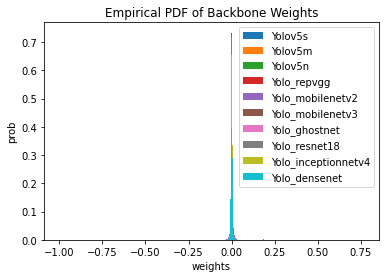

In [11]:
for k, v in model_weights.items():
    weights = np.ones_like(v)/float(len(v))
    plt.hist(np.array(v)/np.max(np.abs(v)), 300, weights=weights, label = k)
plt.title("Empirical PDF of Backbone Weights")
plt.xlabel("weights")
plt.ylabel("prob")
plt.legend()
plt.show()

In [38]:
import warnings
warnings.filterwarnings("ignore")
import thop
from models.yolov5 import Yolov5
from models.yolo_repvgg import Yolo_repvgg
from models.yolo_mobilenet import Yolo_mobilenetv2
from models.yolo_ghostnet import Yolo_ghostnet
from models.yolo_mobilenetv3 import Yolo_mobilenetv3
from models.yolo_resnet18 import Yolo_resnet18


models = [Yolov5('models/yolov5m.yaml'),
          Yolov5('models/yolov5n.yaml'),
          Yolov5('models/yolov5s.yaml'),
#           Yolo_efficientnetv2("models/yolo_efficientnet.yaml"),
          Yolo_inceptionv4("models/yolo_inceptionv4.yaml"),
          Yolo_densenet121("models/yolo_densenet121.yaml"),
          Yolo_repvgg('models/yolo_repvgg.yaml'),
          Yolo_mobilenetv2('models/yolo_mobilenet.yaml'),
          Yolo_mobilenetv3('models/yolo_mobilenetv3.yaml'),
          Yolo_ghostnet('models/yolo_ghostnet.yaml'),
          Yolo_resnet18('models/yolo_resnet18.yaml')
         ]

model_names = ['Yolov5m', 'Yolov5n', 'Yolov5s', 
#                'Yolo_efficientnetv2', 
               "Yolo_inceptionv4", "Yolo_densenet",
               'Yolo_repvgg', 'Yolo_mobilenetv2', 'Yolo_mobilenetv3', 'Yolo_ghostnet', 'Yolo_resnet18']

comp_stats = defaultdict()
for i in model_names:
    comp_stats[i] = defaultdict()
    comp_stats[i]["macs"] = -1
    comp_stats[i]["flops"] = -1
    comp_stats[i]["params"] = -1

dumb = torch.randn(1, 3, 320, 320)
macs_ = []
params_ = []
flops_ = []
for model in range(len(models)):
    macs, params = thop.profile(models[model], inputs=(dumb,), verbose=False)
    macs_.append(macs)
    params_.append(params)
    flops_.append(2*macs)
    print('model:', model_names[model],'{}:  {} macs, {} FLOPs, {} parameters.'.format(model.__class__.__name__, macs, 2*macs, params))
    comp_stats[model_names[model]]["macs"] = int(macs)
    comp_stats[model_names[model]]["flops"] = int(2*macs)    
    comp_stats[model_names[model]]["params"] = int(params)

model: Yolov5m int:  6132247500.0 macs, 12264495000.0 FLOPs, 21190557.0 parameters.
model: Yolov5n int:  564964300.0 macs, 1129928600.0 FLOPs, 1872157.0 parameters.
model: Yolov5s int:  2066557900.0 macs, 4133115800.0 FLOPs, 7235389.0 parameters.
model: Yolo_inceptionv4 int:  15006654943.0 macs, 30013309886.0 FLOPs, 43725313.0 parameters.
model: Yolo_densenet int:  6277318600.0 macs, 12554637200.0 FLOPs, 9239393.0 parameters.
model: Yolo_repvgg int:  6773226300.0 macs, 13546452600.0 FLOPs, 15066081.0 parameters.
model: Yolo_mobilenetv2 int:  981862600.0 macs, 1963725200.0 FLOPs, 3779809.0 parameters.
model: Yolo_mobilenetv3 int:  1011367556.0 macs, 2022735112.0 FLOPs, 4735377.0 parameters.
model: Yolo_ghostnet int:  699490404.0 macs, 1398980808.0 FLOPs, 4807461.0 parameters.
model: Yolo_resnet18 int:  5083216700.0 macs, 10166433400.0 FLOPs, 13234721.0 parameters.


In [14]:
comp_stats

defaultdict(None,
            {'Yolov5m': defaultdict(None,
                         {'macs': 6132247500,
                          'flops': 12264495000,
                          'params': 21190557}),
             'Yolov5n': defaultdict(None,
                         {'macs': 564964300,
                          'flops': 1129928600,
                          'params': 1872157}),
             'Yolov5s': defaultdict(None,
                         {'macs': 2066557900,
                          'flops': 4133115800,
                          'params': 7235389}),
             'Yolo_inceptionv4': defaultdict(None,
                         {'macs': 15006654943,
                          'flops': 30013309886,
                          'params': 43725313}),
             'Yolo_densenet': defaultdict(None,
                         {'macs': 6277318600,
                          'flops': 12554637200,
                          'params': 9239393}),
             'Yolo_repvgg': defaultdict(None,
      

### train loss vs macs/flops/params

In [26]:
# v5 = torch.load(DATA_DIR+'/Yolov5-pytorch2/runs/train/yolov5/weights/last.pt')
# repvgg = torch.load(DATA_DIR+'Yolov5-pytorch2/runs/train/yolo_repvgg/weights/last.pt')
# mobilenetv2 = torch.load(DATA_DIR+'Yolov5-pytorch2/runs/train/yolo_mobilenet/weights/last.pt')
# mobilenetv3 = torch.load(DATA_DIR+'Yolov5-pytorch2/runs/train/yolo_mobilenetv3/weights/last.pt')
# ghostnet = torch.load(DATA_DIR+'Yolov5-pytorch2/runs/train/yolo_ghostnet/weights/last.pt')
# resnet18 = torch.load(DATA_DIR+'Yolov5-pytorch2/runs/train/yolo_resnet18/weights/last.pt')


# v5s = torch.load('/scratch/dz1158/Yolov5-pytorch/runs/train/yolov5s/weights/last.pt')
# v5m = torch.load('/scratch/dz1158/Yolov5-pytorch/runs/train/yolov5m/weights/last.pt')
# v5n = torch.load('/scratch/dz1158/Yolov5-pytorch/runs/train/yolov5n/weights/last.pt')

# repvgg = torch.load('/scratch/dz1158/Yolov5-pytorch/runs/train/yolo_repvgg/weights/last.pt')
# mobilenetv2 = torch.load('/scratch/dz1158/Yolov5-pytorch/runs/train/yolo_mobilenet/weights/last.pt')
# mobilenetv3 = torch.load('/scratch/dz1158/Yolov5-pytorch/runs/train/yolo_mobilenetv3/weights/last.pt')
# ghostnet = torch.load('/scratch/dz1158/Yolov5-pytorch/runs/train/yolo_ghostnet/weights/last.pt')
# resnet18 = torch.load('/scratch/dz1158/Yolov5-pytorch/runs/train/yolo_resnet18/weights/last.pt')

# inceptionv4 = torch.load('/scratch/dz1158/Yolov5-pytorch/runs/train/yolo_inceptionv4/weights/last.pt')
# densenet = torch.load('/scratch/dz1158/Yolov5-pytorch/runs/train/yolo_densenet/weights/last.pt')

model_dicts = [v5m, v5n, v5s, inceptionv4, densenet, repvgg, mobilenetv2, mobilenetv3, ghostnet, resnet18]
model_shortnames = ['V5m', 'V5n', 'V5s', 
               "Incept", "Dense",
               'VGG', 'MobileV2', 'MobileV3', 'Ghost', 'Res18']

model_avglosses = [np.mean(d["train_losses"]) for d in model_dicts]
model_rnglosses = [np.max(d["train_losses"])-np.min(d["train_losses"]) for d in model_dicts]
model_finlosses = [d["train_losses"][-1] for d in model_dicts]
model_normfinlosses = [d["train_losses"][-1]/np.max(d["train_losses"]) for d in model_dicts]
model_macs = [comp_stats[d]["macs"] for d in comp_stats.keys()]
model_flops = [comp_stats[d]["flops"] for d in comp_stats]
model_params = [comp_stats[d]["params"] for d in comp_stats]

In [27]:
temp = np.array(list(zip(model_flops, model_params)))
temp_idx = np.array(model_shortnames)[np.argsort(temp[:,1])]
temp = temp[np.argsort(temp[:,1])]

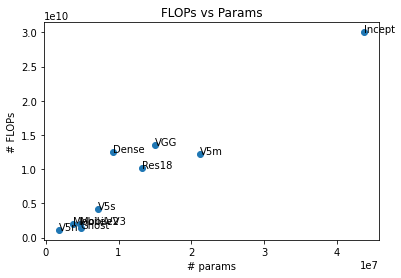

In [30]:
plt.plot(temp[:,1], temp[:,0], 'o')
plt.title("FLOPs vs Params")
plt.xlabel("# params")
plt.ylabel("# FLOPs")
for i in range(len(temp_idx)):
    plt.annotate(temp_idx[i], (temp[:,1][i], temp[:,0][i]))
plt.show()

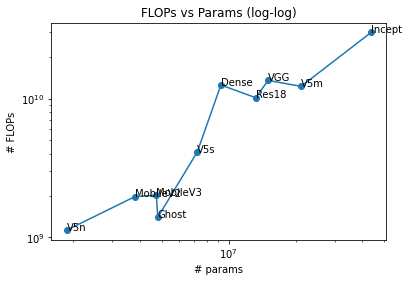

In [31]:
plt.loglog(temp[:,1], temp[:,0], marker='o')
plt.title("FLOPs vs Params (log-log)")
plt.xlabel("# params")
plt.ylabel("# FLOPs")
for i in range(len(temp_idx)):
    plt.annotate(temp_idx[i], (temp[:,1][i], temp[:,0][i]))
plt.show()

### recall/etc vs macs/flops/params

In [33]:
# model_shortnames = ['V5m', 'V5n', 'V5s', "Incept", "Dense", 'VGG', 'MobileV2', 'MobileV3', 'Ghost', 'Res18']
# yolo_names = ["yolov5", "yolo_repvgg", "yolo_mobilenet", "yolo_mobilenetv3", "yolo_ghostnet", "yolo_resnet18"]
yolo_names = ["yolov5m", "yolov5n", "yolov5s", 
              "yolo_inceptionv4", "yolo_densenet", 
              "yolo_repvgg", "yolo_mobilenet", "yolo_mobilenetv3", "yolo_ghostnet", "yolo_resnet18"]

model_etc = defaultdict()
for i in yolo_names:
    model_etc[i] = defaultdict()
    model_etc[i]["recall"] = -1
    model_etc[i]["mAP5"] = -1
    model_etc[i]["mAP5-95"] = -1

cols_list = ["epoch", "train_box_loss", "train_obj_loss", "train_cls_loss", "precision",
            "recall", "mAP5", "mAP5-95", "test_box_loss", "test_obj_loss", "test_cls_loss", "na1", "na2", "na3"]
for i in yolo_names:
    fpth = DATA_DIR + "Yolov5-pytorch/runs/train/" + i + "/results.csv"
    df = pd.read_csv(fpth, names=cols_list)
    model_etc[i]["recall"] = float(np.array(df.recall)[-1])
    model_etc[i]["mAP5"] = float(np.array(df["mAP5"])[-1])
    model_etc[i]["mAP5-95"] = float(np.array(df["mAP5-95"])[-1])
    
model_recalls = [model_etc[i]["recall"] for i in yolo_names]
model_map5 = [model_etc[i]["mAP5"] for i in yolo_names]
model_map595 = [model_etc[i]["mAP5-95"] for i in yolo_names]

In [34]:
blah = np.array(["V5m", "V5n", "V5s", "inceptV4", "dense", "repvgg", "mobileV2", "mobileV3", "ghostnet", "resnet18"])

# plot recall trade off against stats
recall_mac = np.array(list(zip(model_recalls, model_macs)))
rm_idx = blah[np.argsort(recall_mac[:, 1])]
recall_mac = recall_mac[np.argsort(recall_mac[:, 1])]

recall_flop = np.array(list(zip(model_recalls, model_flops)))
rf_idx = blah[np.argsort(recall_flop[:,1])]
recall_flop = recall_flop[np.argsort(recall_flop[:,1])]

recall_param = np.array(list(zip(model_recalls, model_params)))
rp_idx = blah[np.argsort(recall_param[:,1])]
recall_param = recall_param[np.argsort(recall_param[:, 1])]


# plot MAP @ 0.5 trade off against stats
map5_mac = np.array(list(zip(model_map5, model_macs)))
map5_mac_idx = blah[np.argsort(map5_mac[:, 1])]
map5_mac = map5_mac[np.argsort(map5_mac[:, 1])]

map5_flop = np.array(list(zip(model_map5, model_flops)))
map5_flop_idx = blah[np.argsort(map5_flop[:,1])]
map5_flop = map5_flop[np.argsort(map5_flop[:,1])]

map5_param = np.array(list(zip(model_map5, model_params)))
map5_param_idx = blah[np.argsort(map5_param[:,1])]
map5_param = map5_param[np.argsort(map5_param[:, 1])]


# plot MAP @ 0.5-0.95 trade off against stats
map595_mac = np.array(list(zip(model_map595, model_macs)))
map595_mac_idx = blah[np.argsort(map595_mac[:, 1])]
map595_mac = map595_mac[np.argsort(map595_mac[:, 1])]

map595_flop = np.array(list(zip(model_map595, model_flops)))
map595_flop_idx = blah[np.argsort(map595_flop[:,1])]
map595_flop = map595_flop[np.argsort(map595_flop[:,1])]

map595_param = np.array(list(zip(model_map595, model_params)))
map595_param_idx = blah[np.argsort(map595_param[:,1])]
map595_param = map595_param[np.argsort(map595_param[:, 1])]


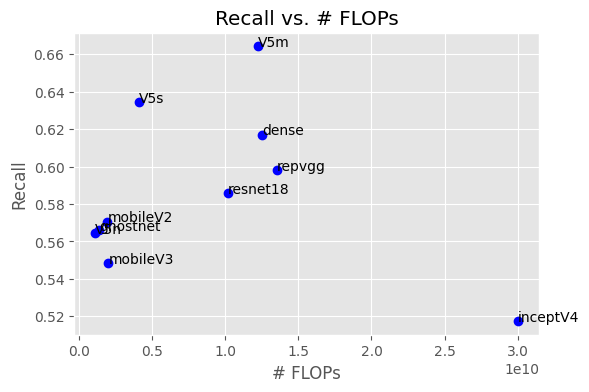

In [96]:
from matplotlib.pyplot import figure
figure(figsize=(6, 4), dpi=100)
plt.style.use('ggplot')

plt.plot(recall_flop[:,1], recall_flop[:,0], "o", color = "b") 
plt.title("Recall vs. # FLOPs")
plt.xlabel("# FLOPs")
plt.ylabel("Recall")
for i in range(len(rf_idx)):
    plt.annotate(rf_idx[i], (recall_flop[:,1][i], recall_flop[:,0][i]))
plt.show()

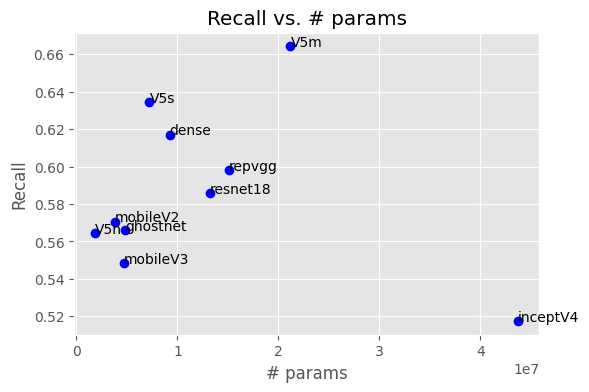

In [85]:
figure(figsize=(6, 4), dpi=100)

plt.plot(recall_param[:,1], recall_param[:,0], "o", color="b") 
plt.title("Recall vs. # params")
plt.xlabel("# params")
plt.ylabel("Recall")
for i in range(len(rp_idx)):
    plt.annotate(rp_idx[i], (recall_param[:,1][i], recall_param[:,0][i]))
plt.show()

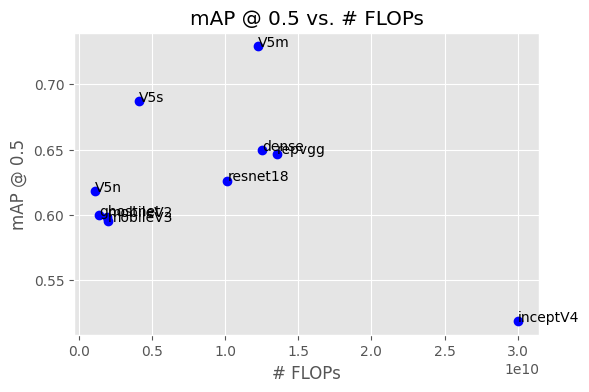

In [87]:
figure(figsize=(6, 4), dpi=100)

plt.plot(map5_flop[:,1], map5_flop[:,0], "o", color = "b") 
plt.title("mAP @ 0.5 vs. # FLOPs")
plt.xlabel("# FLOPs")
plt.ylabel("mAP @ 0.5")
for i in range(len(map5_flop_idx)):
    plt.annotate(map5_flop_idx[i], (map5_flop[:,1][i], map5_flop[:,0][i]))
plt.show()

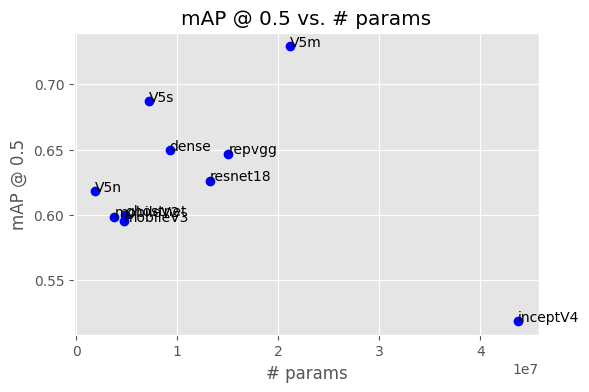

In [84]:
figure(figsize=(6, 4), dpi=100)
plt.plot(map5_param[:,1], map5_param[:,0], "o", color = "b") 
plt.title("mAP @ 0.5 vs. # params")
plt.xlabel("# params")
plt.ylabel("mAP @ 0.5")
for i in range(len(map5_param_idx)):
    plt.annotate(map5_param_idx[i], (map5_param[:,1][i], map5_param[:,0][i]))
plt.show()

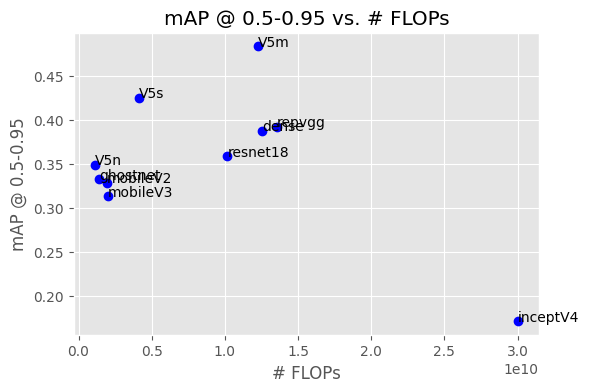

In [88]:
figure(figsize=(6, 4), dpi=100)

plt.plot(map595_flop[:,1], map595_flop[:,0], "o", color = "b") 
plt.title("mAP @ 0.5-0.95 vs. # FLOPs")
plt.xlabel("# FLOPs")
plt.ylabel("mAP @ 0.5-0.95")
for i in range(len(map595_flop_idx)):
    plt.annotate(map595_flop_idx[i], (map595_flop[:,1][i], map595_flop[:,0][i]))
plt.show()

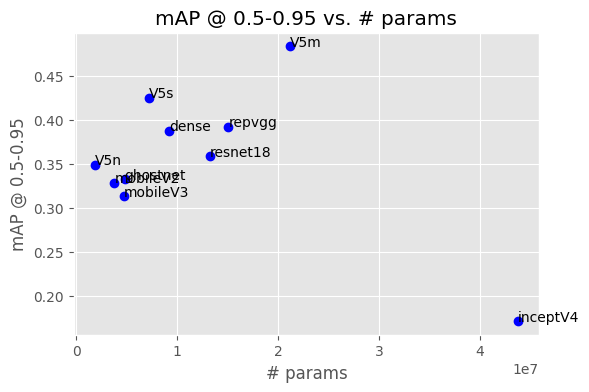

In [89]:
figure(figsize=(6, 4), dpi=100)

plt.plot(map595_param[:,1], map595_param[:,0], "o", color = "b") 
plt.title("mAP @ 0.5-0.95 vs. # params")
plt.xlabel("# params")
plt.ylabel("mAP @ 0.5-0.95")
for i in range(len(map595_param_idx)):
    plt.annotate(map595_param_idx[i], (map595_param[:,1][i], map595_param[:,0][i]))
plt.show()

In [61]:
# blah = np.array(["Yolov5", "repvgg", "mobileV2", "mobileV3", "ghostnet", "resnet18"])
blah = np.array(["V5m", "V5n", "V5s", "inceptV4", "dense", "repvgg", "mobileV2", "mobileV3", "ghostnet", "resnet18"])

a = np.array(list(zip(model_finlosses, model_macs)))
ablah = blah[np.argsort(a[:, 1])]
a = a[np.argsort(a[:, 1])]

b = np.array(list(zip(model_finlosses, model_flops)))
bblah = blah[np.argsort(b[:,1])]
b = b[np.argsort(b[:,1])]

c = np.array(list(zip(model_finlosses, model_params)))
cblah = blah[np.argsort(c[:,1])]
c = c[np.argsort(c[:, 1])]

a2 = np.array(list(zip(model_normfinlosses, model_macs)))
a2blah = blah[np.argsort(a2[:,1])]
a2 = a2[np.argsort(a2[:, 1])]

b2 = np.array(list(zip(model_normfinlosses, model_flops)))
b2blah = blah[np.argsort(b2[:,1])]
b2 = b2[np.argsort(b2[:,1])]

c2 = np.array(list(zip(model_normfinlosses, model_params)))
c2blah = blah[np.argsort(c2[:,1])]
c2 = c2[np.argsort(c2[:, 1])]

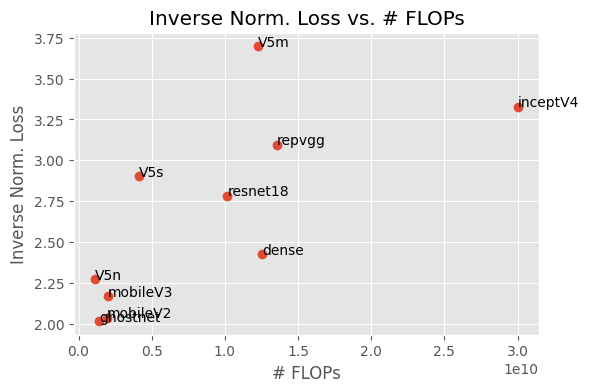

In [63]:
figure(figsize=(6, 4), dpi=100)

plt.plot(b2[:,1], 1/b2[:,0], "o") 
plt.title("Inverse Norm. Loss vs. # FLOPs") #smaller loss ==> larger inverse loss
plt.xlabel("# FLOPs")
plt.ylabel("Inverse Norm. Loss")
for i in range(len(b2blah)):
    plt.annotate(b2blah[i], (b2[:,1][i], 1/(b2[:,0][i])))
plt.show()

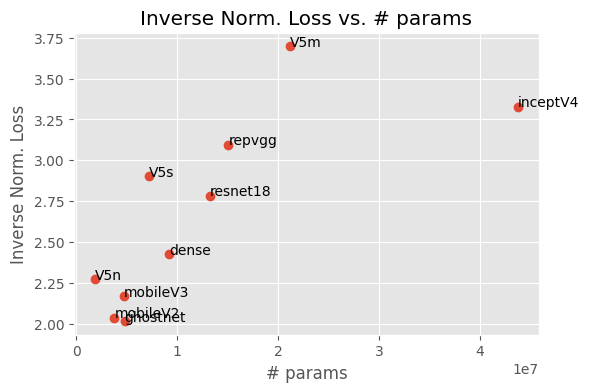

In [98]:
figure(figsize=(6, 4), dpi=100)

plt.plot(c2[:,1], (1/c2[:,0]), "o")
plt.title("Inverse Norm. Loss vs. # params")
plt.xlabel("# params")
plt.ylabel("Inverse Norm. Loss")
for i in range(len(c2blah)):
    plt.annotate(c2blah[i], (c2[:,1][i], 1/(c2[:,0][i])))
plt.show()

In [131]:
regr2 = LinearRegression(fit_intercept=True)
y2 = ((np.log(1/c2[:,0]) - np.mean( np.log(1/c2[:,0]) ))/np.std(np.log(1/c2[:,0]))).reshape(-1,1)
x2 = ((np.log(c2[:,1]) - np.mean(np.log(c2[:,1])))/np.std(np.log(c2[:,1]))).reshape(-1,1)
#x2 = np.log(np.array([1872157, 4807461, 3779809, 4735377, 7235389, 13234721, 21190557,  9239393,15066081,43725313])).reshape(-1,1)
#X = np.concatenate((x, x2), axis=1)
regr2.fit(x2,y2)

pred2 = regr2.predict(x2)
print("Coefficients: \n", regr2.coef_)

Coefficients: 
 [[    0.83495]]


In [132]:
c2blah_v5_idx = [0, 4, 8] # indices for YOLOv5 only
c2blah_v5 = c2blah[c2blah_v5_idx]
c2_v5 = c2[c2blah_v5_idx,:]

regr2_v5 = LinearRegression(fit_intercept=True)
y2_v5 = ((np.log(1/c2_v5[:,0]) - np.mean( np.log(1/c2_v5[:,0]) ))/np.std(np.log(1/c2_v5[:,0]))).reshape(-1,1)
x2_v5 = ((np.log(c2_v5[:,1]) - np.mean(np.log(c2_v5[:,1])))/np.std(np.log(c2_v5[:,1]))).reshape(-1,1)
#x2 = np.log(np.array([1872157, 4807461, 3779809, 4735377, 7235389, 13234721, 21190557,  9239393,15066081,43725313])).reshape(-1,1)
#X = np.concatenate((x, x2), axis=1)
regr2_v5.fit(x2_v5,y2_v5)

pred2_v5 = regr2_v5.predict(x2_v5)
print("Coefficients: \n", regr2_v5.coef_)

Coefficients: 
 [[    0.99803]]


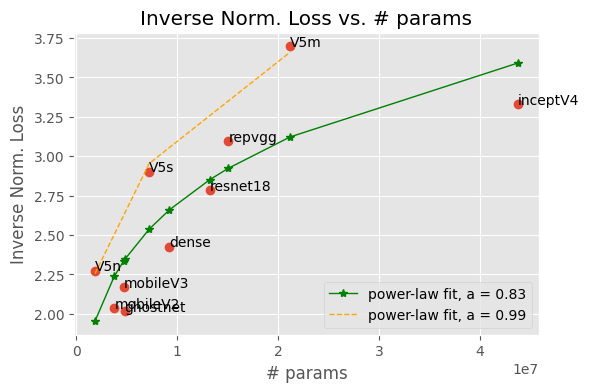

In [144]:
figure(figsize=(6, 4), dpi=100)

plt.plot(c2[:,1], 1/c2[:,0], "o") 
plt.title("Inverse Norm. Loss vs. # params") #smaller loss ==> larger inverse loss
plt.xlabel("# params")
plt.ylabel("Inverse Norm. Loss")
for i in range(len(c2blah)):
    plt.annotate(c2blah[i], (c2[:,1][i], 1/(c2[:,0][i])))

plt.plot(np.exp(x2*np.std(np.log(c2[:,1])) + np.mean(np.log(c2[:,1]))), 
         np.exp(pred2*np.std(np.log(1/c2[:,0])) + np.mean(np.log(1/c2[:,0]))), color="green", marker="*", 
         label = "power-law fit, a = 0.83", linewidth=1)

plt.plot(np.exp(x2_v5 * np.std(np.log(c2_v5[:,1])) + np.mean(np.log(c2_v5[:,1]))), 
         np.exp(pred2_v5 * np.std(np.log(1/c2_v5[:,0])) + np.mean(np.log(1/c2_v5[:,0]))), "--", color="orange", 
         label = "power-law fit, a = 0.99", linewidth=1)

plt.legend()
plt.show()

In [127]:
c2blah_v5_idx = [0, 4, 8] # indices for YOLOv5 only
c2blah_v5 = c2blah[c2blah_v5_idx]
c2_v5 = c2[c2blah_v5_idx,:]

regr2_v5 = LinearRegression(fit_intercept=True)
y2_v5 = ((np.log(1/c2_v5[:,0]) - np.mean( np.log(1/c2_v5[:,0]) ))/np.std(np.log(1/c2_v5[:,0]))).reshape(-1,1)
x2_v5 = ((np.log(c2_v5[:,1]) - np.mean(np.log(c2_v5[:,1])))/np.std(np.log(c2_v5[:,1]))).reshape(-1,1)
#x2 = np.log(np.array([1872157, 4807461, 3779809, 4735377, 7235389, 13234721, 21190557,  9239393,15066081,43725313])).reshape(-1,1)
#X = np.concatenate((x, x2), axis=1)
regr2_v5.fit(x2_v5,y2_v5)

pred2_v5 = regr2_v5.predict(x2_v5)
print("Coefficients: \n", regr2_v5.coef_)

LinearRegression()

Coefficients: 
 [[    0.83378]]


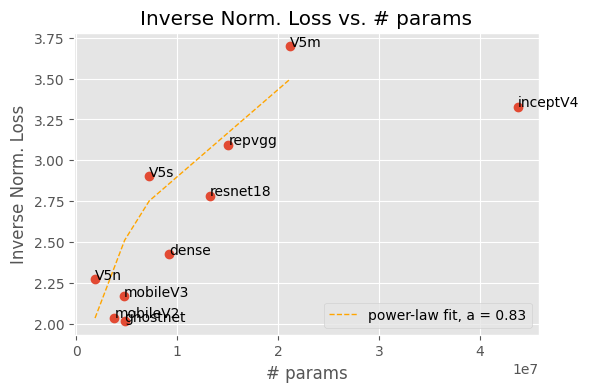

In [128]:
# Plot outputs
figure(figsize=(6, 4), dpi=100)

plt.plot(c2[:,1], 1/c2[:,0], "o") 
plt.title("Inverse Norm. Loss vs. # params") #smaller loss ==> larger inverse loss
plt.xlabel("# params")
plt.ylabel("Inverse Norm. Loss")
for i in range(len(c2blah)):
    plt.annotate(c2blah[i], (c2[:,1][i], 1/(c2[:,0][i])))

plt.plot(np.exp(x2_v5 * np.std(np.log(c2_v5[:,1])) + np.mean(np.log(c2_v5[:,1]))), 
         np.exp(pred2_v5 * np.std(np.log(1/c2_v5[:,0])) + np.mean(np.log(1/c2_v5[:,0]))), "--", color="orange", 
         label = "power-law fit, a = 0.83", linewidth=1)
plt.legend()
plt.show()

In [49]:
import sklearn
from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error, r2_score

In [74]:
regr = LinearRegression(fit_intercept=True)
y = ((np.log(1/b2[:,0]) - np.mean( np.log(1/b2[:,0]) ))/np.std(np.log(1/b2[:,0]))).reshape(-1,1)
x = ((np.log(b2[:,1]) - np.mean(np.log(b2[:,1])))/np.std(np.log(b2[:,1]))).reshape(-1,1)
#x2 = np.log(np.array([1872157, 4807461, 3779809, 4735377, 7235389, 13234721, 21190557,  9239393,15066081,43725313])).reshape(-1,1)
#X = np.concatenate((x, x2), axis=1)
regr.fit(x,y)
pred = regr.predict(x)
print("Coefficients: \n", regr.coef_)

LinearRegression()

In [147]:
b2blah_v5_idx = [0, 4, 6] # indices for YOLOv5 only
b2blah_v5 = b2blah[b2blah_v5_idx]
b2_v5 = b2[b2blah_v5_idx,:]

regr_v5 = LinearRegression(fit_intercept=True)
y_v5 = ((np.log(1/b2_v5[:,0]) - np.mean( np.log(1/b2_v5[:,0]) ))/np.std(np.log(1/b2_v5[:,0]))).reshape(-1,1)
x_v5 = ((np.log(b2_v5[:,1]) - np.mean(np.log(b2_v5[:,1])))/np.std(np.log(b2_v5[:,1]))).reshape(-1,1)
#x2 = np.log(np.array([1872157, 4807461, 3779809, 4735377, 7235389, 13234721, 21190557,  9239393,15066081,43725313])).reshape(-1,1)
#X = np.concatenate((x, x2), axis=1)
regr_v5.fit(x_v5,y_v5)

pred_v5 = regr_v5.predict(x_v5)
print("Coefficients: \n", regr_v5.coef_)

Coefficients: 
 [[    0.99887]]


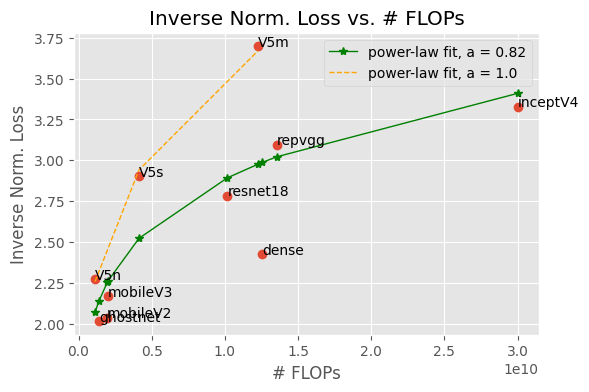

In [148]:
# print("Mean squared error: %.2f" % mean_squared_error(np.exp(y), np.exp(pred)))
# print("Coefficient of determination: %.2f" % r2_score(diabetes_y_test, diabetes_y_pred))

# Plot outputs
figure(figsize=(6, 4), dpi=100)

plt.plot(b2[:,1], 1/b2[:,0], "o") 
plt.title("Inverse Norm. Loss vs. # FLOPs") #smaller loss ==> larger inverse loss
plt.xlabel("# FLOPs")
plt.ylabel("Inverse Norm. Loss")
for i in range(len(b2blah)):
    plt.annotate(b2blah[i], (b2[:,1][i], 1/(b2[:,0][i])))

plt.plot(np.exp(x*np.std(np.log(b2[:,1])) + np.mean(np.log(b2[:,1]))), np.exp(pred*np.std(np.log(1/b2[:,0])) + np.mean(np.log(1/b2[:,0]))), color="green", marker="*", 
         label = "power-law fit, a = 0.82", linewidth=1)

plt.plot(np.exp(x_v5 * np.std(np.log(b2_v5[:,1])) + np.mean(np.log(b2_v5[:,1]))), 
         np.exp(pred_v5 * np.std(np.log(1/b2_v5[:,0])) + np.mean(np.log(1/b2_v5[:,0]))), "--", color="orange", 
         label = "power-law fit, a = 1.0", linewidth=1)

plt.legend()
plt.show()